# Comparator for countries

This is a WOP of a indicator comparator for countries.
Aka, "What makes your country special ?"

- We extract the metrics for two entities (currently Spain . vs world)

- Calculate the regression and coisine distance for each metric.

- Display metrics with lower values (Your country behaviour for that metrics is similar)

- Display metrics with higher values (Your country behaviour for that metrics is different)


In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
from scipy.spatial import distance 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing


pd.set_option("display.width"    , 1000)
pd.set_option("display.max_rows" , 1500)

In [2]:
conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')

In [158]:
CountryCode = 'EMU'
pd.read_sql(f"""SELECT CountryName
               FROM Indicators
               WHERE CountryCode = '{CountryCode}'
               LIMIT 1""",
           conn).values[0][0]


'Euro area'

In [4]:
pd.read_sql("""SELECT distinct(CountryName),CountryCode
               FROM Indicators Where CountryName = 'Spain'
               OR CountryName = 'Euro area' """,
           conn)

,CountryName,CountryCode
0,Euro area,EMU
1,Spain,ESP


In [169]:
indicators = pd.read_sql("""SELECT distinct(IndicatorName) as indicator
               FROM Indicators Where CountryName = 'Spain' """,
           conn)

indicators_array = indicators.indicator.values
indicator_array

{'Access to electricity (% of population)',
 'Access to electricity, rural (% of rural population)',
 'Access to electricity, urban (% of urban population)',
 'Access to non-solid fuel (% of population)',
 'Access to non-solid fuel, rural (% of rural population)',
 'Access to non-solid fuel, urban (% of urban population)',
 'Adjusted net enrolment rate, primary, both sexes (%)',
 'Adjusted net enrolment rate, primary, female (%)',
 'Adjusted net enrolment rate, primary, male (%)',
 'Adjusted net national income (annual % growth)',
 'Adjusted net national income (constant 2005 US$)',
 'Adjusted net national income (current US$)',
 'Adjusted net national income per capita (annual % growth)',
 'Adjusted net national income per capita (constant 2005 US$)',
 'Adjusted net national income per capita (current US$)',
 'Adjusted net savings, excluding particulate emission damage (% of GNI)',
 'Adjusted net savings, including particulate emission damage (% of GNI)',
 'Adjusted savings: carbon di

In [6]:
IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'ESP'

df = pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode   = '{CountryCode}'  """,
           conn)
df


,IndicatorName,IndicatorCode,Year,Value
0,GDP (constant LCU),NY.GDP.MKTP.KN,1960,1.692414e+11
1,GDP (constant LCU),NY.GDP.MKTP.KN,1961,1.892774e+11
2,GDP (constant LCU),NY.GDP.MKTP.KN,1962,2.081170e+11
3,GDP (constant LCU),NY.GDP.MKTP.KN,1963,2.280889e+11
4,GDP (constant LCU),NY.GDP.MKTP.KN,1964,2.401971e+11
5,GDP (constant LCU),NY.GDP.MKTP.KN,1965,2.552169e+11
6,GDP (constant LCU),NY.GDP.MKTP.KN,1966,2.737101e+11
7,GDP (constant LCU),NY.GDP.MKTP.KN,1967,2.855900e+11
8,GDP (constant LCU),NY.GDP.MKTP.KN,1968,3.044305e+11
9,GDP (constant LCU),NY.GDP.MKTP.KN,1969,3.315461e+11


In [7]:
x = df[['Year','Value']].values
length = df.shape[0]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled


array([[0.        , 0.        ],
       [0.01851852, 0.02105548],
       [0.03703704, 0.04085375],
       [0.05555556, 0.06184197],
       [0.07407407, 0.07456622],
       [0.09259259, 0.09035036],
       [0.11111111, 0.10978456],
       [0.12962963, 0.12226902],
       [0.14814815, 0.14206816],
       [0.16666667, 0.17056362],
       [0.18518519, 0.18551395],
       [0.2037037 , 0.20240862],
       [0.22222222, 0.23339901],
       [0.24074074, 0.26542925],
       [0.25925926, 0.29033635],
       [0.27777778, 0.29287489],
       [0.2962963 , 0.30842677],
       [0.31481481, 0.3222302 ],
       [0.33333333, 0.32954644],
       [0.35185185, 0.32975724],
       [0.37037037, 0.34096898],
       [0.38888889, 0.3402817 ],
       [0.40740741, 0.34674006],
       [0.42592593, 0.35602597],
       [0.44444444, 0.36555405],
       [0.46296296, 0.3781689 ],
       [0.48148148, 0.39625809],
       [0.5       , 0.42810476],
       [0.51851852, 0.45897423],
       [0.53703704, 0.48971409],
       [0.

In [8]:

#X = [ i[0] for i in x_scaled]
#Y = [ i[1] for i in x_scaled]
#print (X.shape())
#X = X.reshape(length,1)
#Y = Y.reshape(length,1)
#length = df.shape[0]

#linear_regressor = LinearRegression()
#linear_regressor.fit(x_scaled,2)


In [9]:

#x = df['Year' ].values
#y = df['Value'].values
#x = x.reshape(length,1)
#y = y.reshape(length,1)
#regr = LinearRegression()
#regr.fit(x,y)


vacio, GDP (constant LCU)


,CountryName,IndicatorName,IndicatorCode,Year,Value
0,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1960,1.692414e+11
1,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1961,1.892774e+11
2,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1962,2.081170e+11
3,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1963,2.280889e+11
4,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1964,2.401971e+11
5,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1965,2.552169e+11
6,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1966,2.737101e+11
7,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1967,2.855900e+11
8,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1968,3.044305e+11
9,Spain,GDP (constant LCU),NY.GDP.MKTP.KN,1969,3.315461e+11


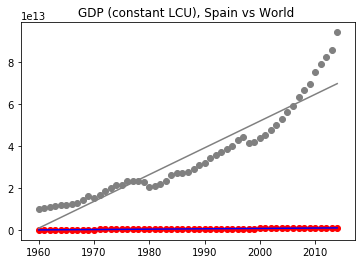

In [159]:
def Draw_Difference(IndicatorName,CountryCode1, CountryCode2):
    """ Draw difference between a country and the rest of the world"""
    CountryCode = CountryCode1
    conn = sqlite3.connect('../input/world-development-indicators/database.sqlite')
    df = pd.read_sql(f"""SELECT CountryName,IndicatorName,IndicatorCode,Year,Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode}'  """,
               conn)

    length = df.shape[0]

    x = df['Year' ].values
    y = df['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    fig = plt.figure()
    plt.scatter(x,y,color='red')
    regr = LinearRegression()
    regr.fit(x,y)
    plt.plot(x,regr.predict(x),color='blue')
    otro =  pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode != '{CountryCode}' 
                     AND CountryCode = '{CountryCode2}' 
                     AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode}')
                     AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode}')
                     group by Year""",
               conn)
    
    if otro.shape[0] == 0 :
        print(f"vacio, {IndicatorName}")
        otro =  pd.read_sql(f"""SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode != '{CountryCode}' 
                 AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode}')
                 AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode}')
                 group by Year""",
           conn)
    
    length = otro.shape[0]

    x = otro['Year' ].values
    y = otro['Value'].values
    x = x.reshape(length,1)
    y = y.reshape(length,1)
    regr = LinearRegression()
    regr.fit(x,y)

    large_name  = df.CountryName.values[0]
    # Get Large name for the title
    CountryName2 = pd.read_sql(f"""SELECT CountryName
               FROM Indicators
               WHERE CountryCode = '{CountryCode2}'
               LIMIT 1""",
           conn).values[0][0]
    
    plt.title(f"{IndicatorName}, {large_name} vs {CountryName2} ")
    plt.scatter(x,y,color='gray')
    plt.plot(x,regr.predict(x),color='gray')
    return plt ,df,otro

IndicatorName = 'GDP (constant LCU)'
CountryCode1   = 'ESP'
CountryCode2   = 'WLD'

plt ,df,otro = Draw_Difference(IndicatorName,CountryCode1,CountryCode2)
df


In [11]:
IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'ESP'

df = pd.read_sql(f"""SELECT CountryName,IndicatorName,IndicatorCode,Year,Value
               FROM Indicators
               WHERE IndicatorName = '{IndicatorName}' 
                 AND CountryCode   = '{CountryCode}'  """,
           conn)

length = df.shape[0]


In [12]:
slope , intercept , r_value ,p_value,std_err = spstats.linregress(df.Year,df.Value)

In [13]:
print(slope , intercept , r_value ,p_value,std_err)

17709874096.524055 -34558461204175.832 0.9860319284493773 6.114889802252873e-43 410911125.0354207


In [190]:

import traceback
def get_comparision_df(CountryCode1,CountryCode2,filter_indicator='%',DEBUG=False):
    """ Compare two countries with a specific filter"""
    result_array = []
    df_result = pd.DataFrame()

    # We extract indicator from
    df_indicators = pd.read_sql(f"""
                   SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = '{CountryCode1}'
                          AND IndicatorName LIKE  '%{filter_indicator}%' """,
               conn)
    if DEBUG : print(f"""SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = '{CountryCode1}'
                          AND IndicatorName LIKE  '%{filter_indicator}%' """)
    df_world = pd.read_sql(f"""
                  SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode   = '{CountryCode2}' 
                          AND IndicatorName LIKE  '%{filter_indicator}%'""",
               conn)
    if DEBUG : print(f"""2 : SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode   = '{CountryCode2}' 
                          AND IndicatorName LIKE  '%{filter_indicator}%' """)
    
    indicators_array = df_indicators.IndicatorName.values
    world_array      = df_world.IndicatorName.values
    indicator_array  = set(indicators_array) & set( world_array)
    indicator_array_size = len (indicator_array)
    if DEBUG : print(f"""Indicadores::: df_indicators,{df_indicators.shape}, df_world,{df_world.shape}, indicator_array_size,{indicator_array_size}""")
    # Get Diferences between a country and the rest
    for IndicatorName in indicators_array :
        try :
            otro =  pd.read_sql(f"""
                   SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode2}' 
                     AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')
                     AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')
                     group by Year,IndicatorName,IndicatorCode
                     """,
               conn)
            if DEBUG : print(f"""
                     SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = '{IndicatorName}' 
                     AND CountryCode   = '{CountryCode2}' 
                     AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')
                     AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')
                     group by Year,IndicatorName,IndicatorCode""", otro.shape)
            length         = otro.shape[0]
            if length == 0 : 
                if DEBUG : print(f"Vacio: {IndicatorName} otro")
                continue
            else :
                 if DEBUG : print(f"otro length {length}")

            x              = otro[['Year','Value']].values
            min_max_scaler = preprocessing.MinMaxScaler()
            otro_scaled    = min_max_scaler.fit_transform(x)
            x_otro         = [ point[1] for point in otro_scaled ]

            df = pd.read_sql(f"""
                        SELECT IndicatorName,IndicatorCode,Year,Value
                        FROM Indicators
                        WHERE IndicatorName = '{IndicatorName}' 
                            AND CountryCode   = '{CountryCode1}' 
                            AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')
                            AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')""",
                       conn)
            if DEBUG : print(f"""
                        SELECT IndicatorName,IndicatorCode,Year,Value
                        FROM Indicators
                        WHERE IndicatorName = '{IndicatorName}' 
                            AND CountryCode   = '{CountryCode1}' 
                            AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = '{IndicatorName}' AND CountryCode   = '{CountryCode1}')
                            AND Year <= (SELECT max(Year) FROM Indicators 
                            """)

            length = df.shape[0]
            if length == 0 : 
                if DEBUG : print(f"Vacio: {IndicatorName} df")
                continue
            
            if DEBUG : print(f"sizes : otro.shape[0] , {df.shape[0]}  ")

            x = df[['Year','Value']].values
            df_scaled = min_max_scaler.fit_transform(x)
            x_df         = [ point[1] for point in df_scaled ]


            #dst = distance.cosine(df.Value,otro.Value)
            dst = distance.cosine(x_otro,x_df)

            result_array.append({ 
                "value"          : dst, 
                "CountryCode"    : CountryCode1 , 
                'CountryCompare' : CountryCode2 , 
                "IndicatorName"  : IndicatorName  } )
            
        except Exception as e : 
            print(IndicatorName,e)
    df_result = pd.DataFrame(result_array) 

    length = df_result.shape[0]
    if DEBUG : print(df_result.columns,length)

    if length == 0 : 
        if DEBUG : print(f"Vacio: {IndicatorName} al the end")
        return None
    df_result = df_result[df_result['value'].notna()]
    df_result = df_result.sort_values('value')
    return df_result

IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'ESP'

df_result = get_comparision_df('ESP','EMU','nuclear',True)
df_result


SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = 'ESP'
                          AND IndicatorName LIKE  '%nuclear%' 
2 : SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode   = 'EMU' 
                          AND IndicatorName LIKE  '%nuclear%' 
Indicadores::: df_indicators,(2, 1), df_world,(2, 1), indicator_array_size,2

                     SELECT IndicatorName,IndicatorCode,Year,AVG(Value) As Value
                   FROM Indicators
                   WHERE IndicatorName = 'Alternative and nuclear energy (% of total energy use)' 
                     AND CountryCode   = 'EMU' 
                     AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = 'Alternative and nuclear energy (% of total energy use)' AND CountryCode   = 'ESP')
                     AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = 'Al

# Why Spain is NOT different to euro zone

We print those indicators with the lowers cosine distance

,value,CountryCode,CountryCompare,IndicatorName
239,0.000000,ESP,EMU,Emigration rate of tertiary educated (% of tot...
386,0.000000,ESP,EMU,Low-birthweight babies (% of births)
485,0.000000,ESP,EMU,"Access to non-solid fuel, rural (% of rural po..."
493,0.000000,ESP,EMU,Ease of doing business index (1=most business-...
389,0.000000,ESP,EMU,"Cause of death, by injury (% of total)"
294,0.000000,ESP,EMU,Population living in areas where elevation is ...
390,0.000000,ESP,EMU,"Cause of death, by non-communicable diseases (..."
490,0.000031,ESP,EMU,Profit tax (% of commercial profits)
283,0.000038,ESP,EMU,"Mortality rate, infant, male (per 1,000 live b..."
282,0.000057,ESP,EMU,"Mortality rate, infant, female (per 1,000 live..."


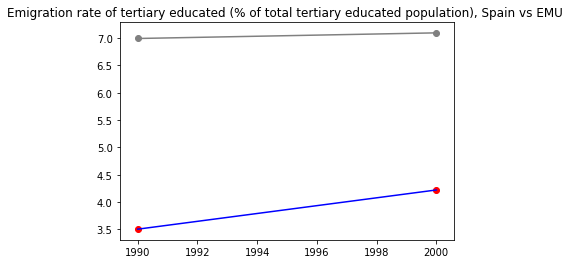

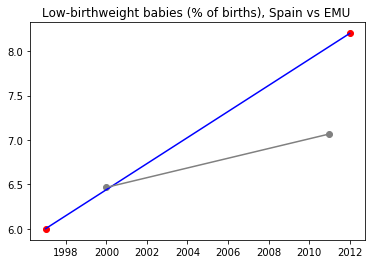

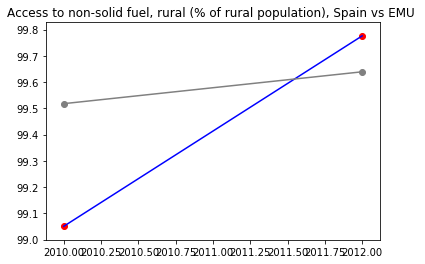

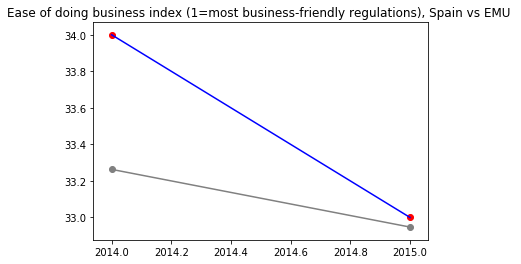

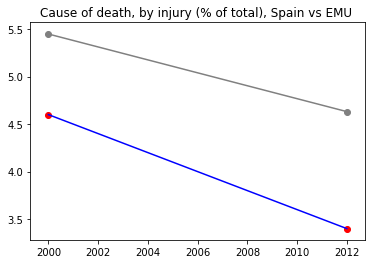

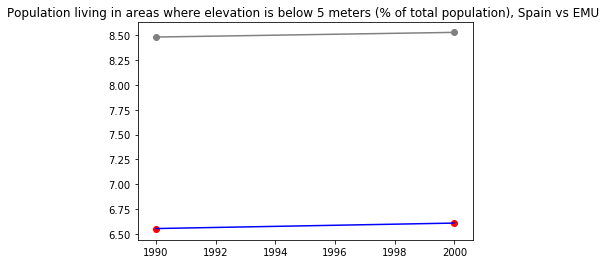

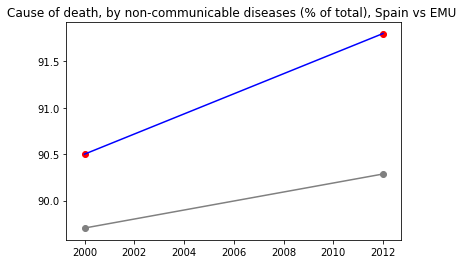

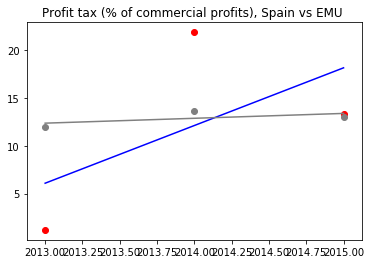

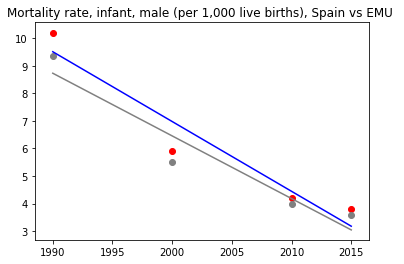

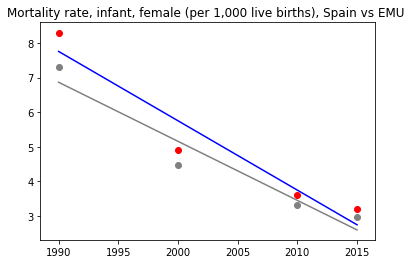

In [149]:
CountryCompare = df_result.CountryCompare.values[0]
for IndicatorName in df_result.head(10).IndicatorName.values :
        plt ,df_country,df_rest = Draw_Difference(IndicatorName,CountryCode,CountryCompare)

df_result.head(10)
        

# Why Spain is different to euro zone

We draw those indicators with the highest cosine distance


<ipython-input-139-173ed19a07ef>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-139-173ed19a07ef>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-139-173ed19a07ef>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-139-

<ipython-input-139-173ed19a07ef>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-139-173ed19a07ef>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-139-173ed19a07ef>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
<ipython-input-139-

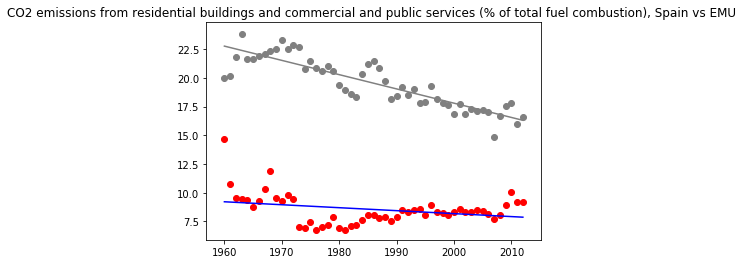

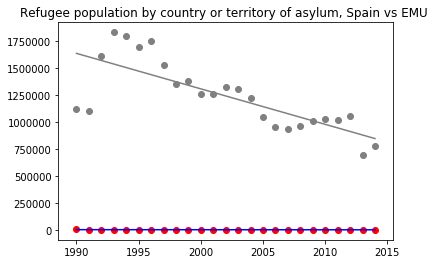

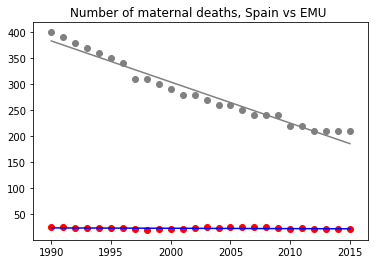

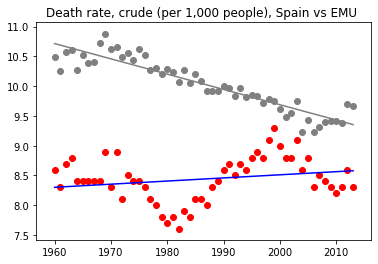

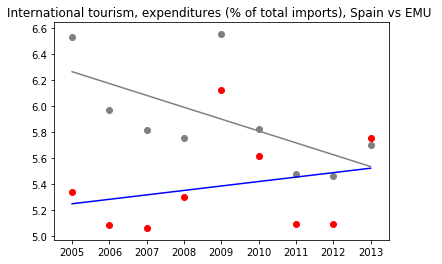

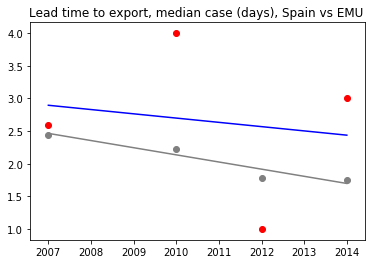

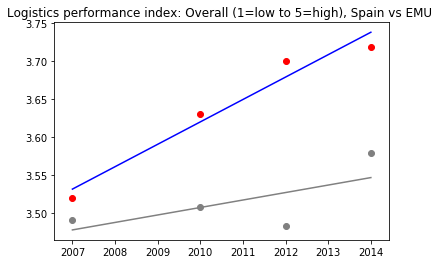

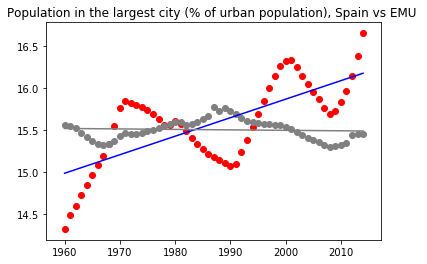

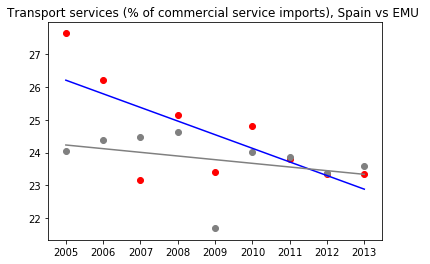

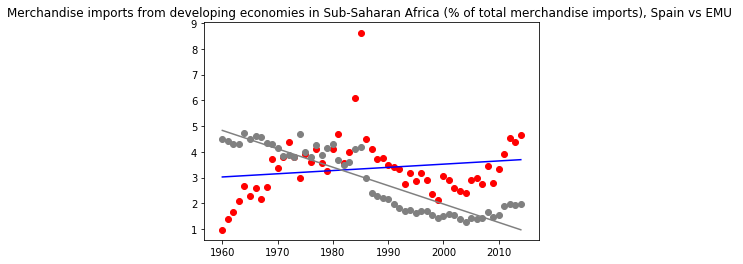

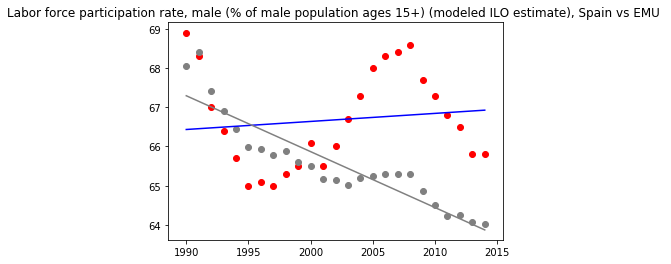

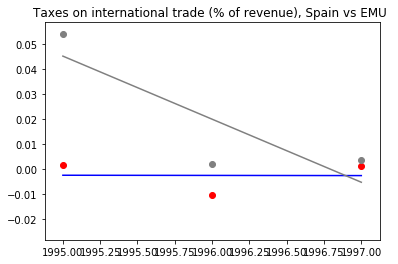

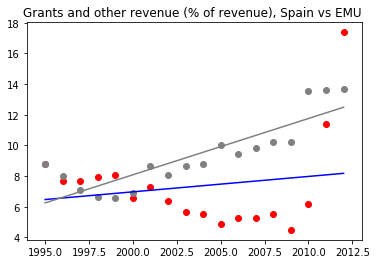

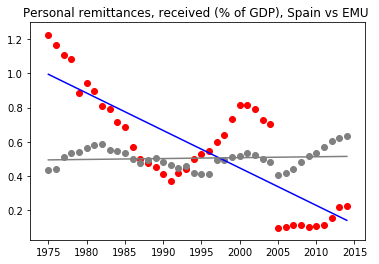

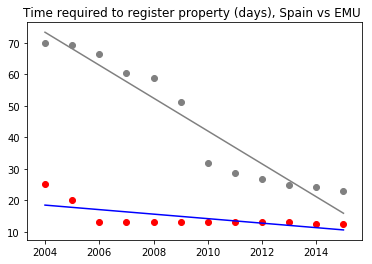

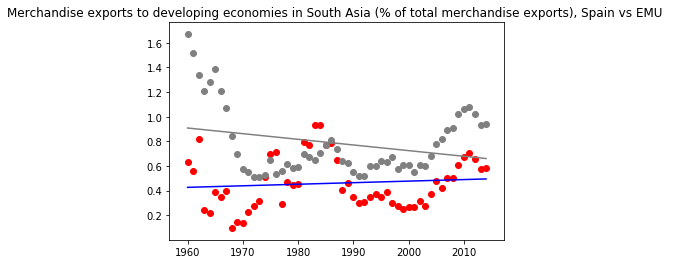

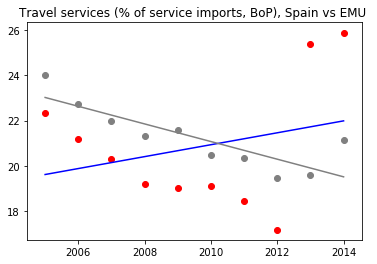

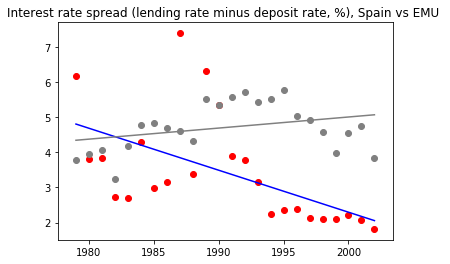

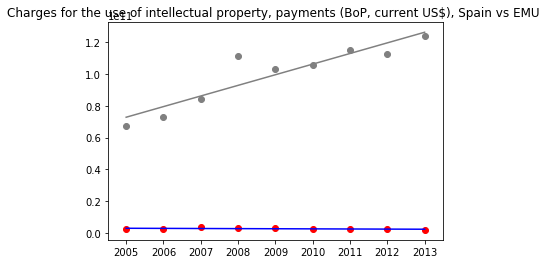

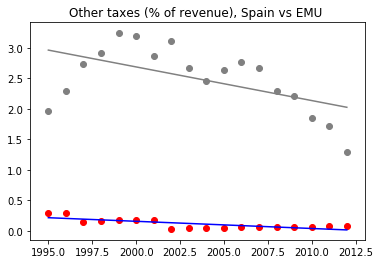

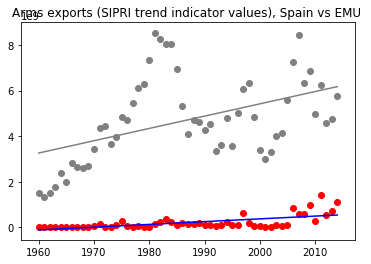

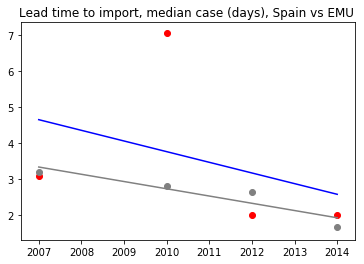

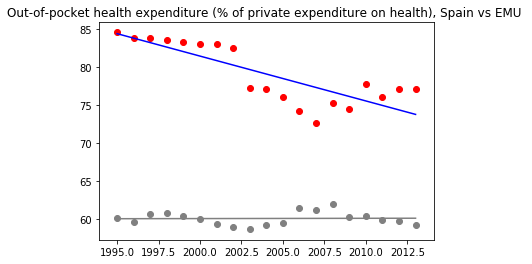

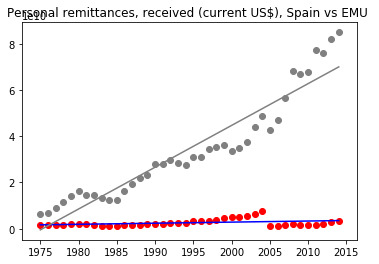

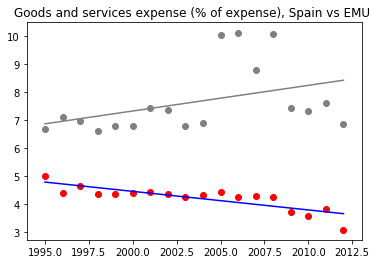

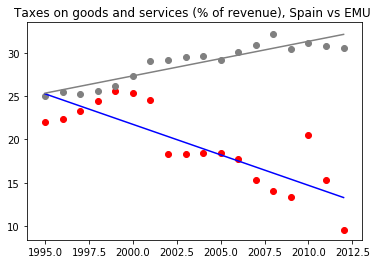

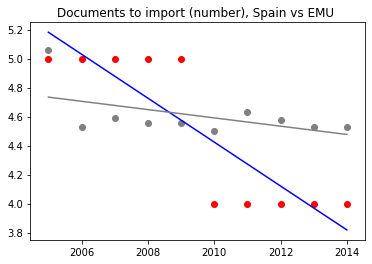

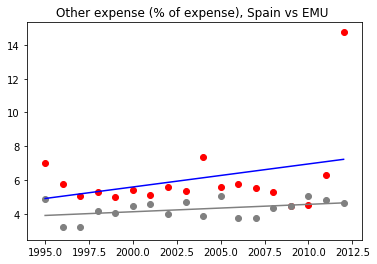

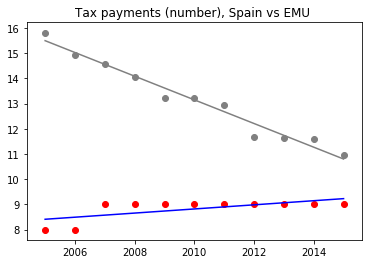

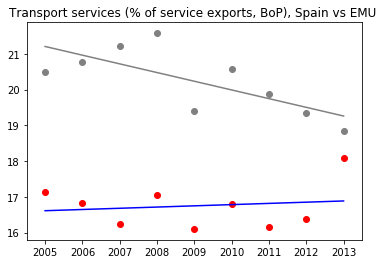

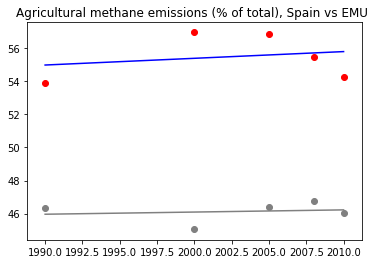

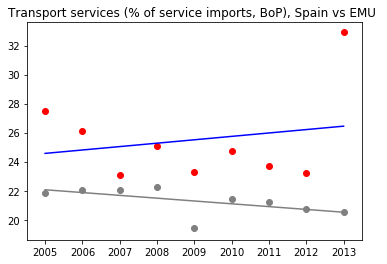

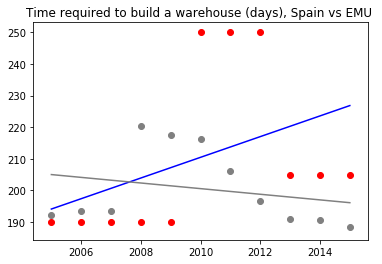

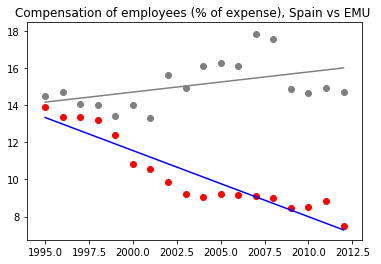

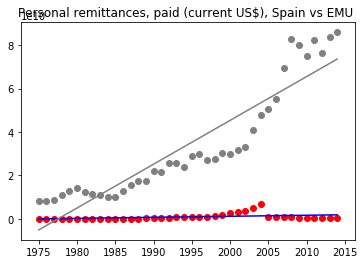

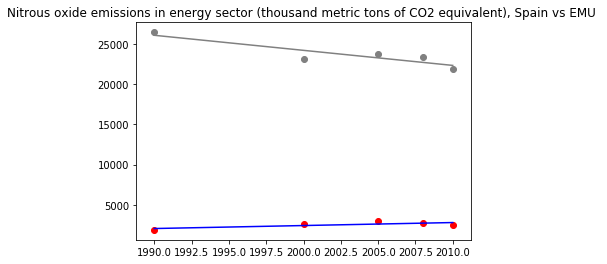

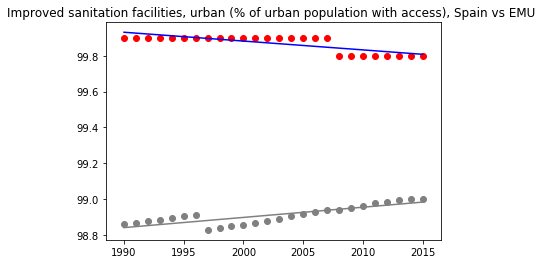

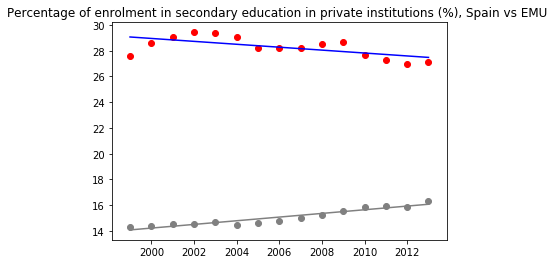

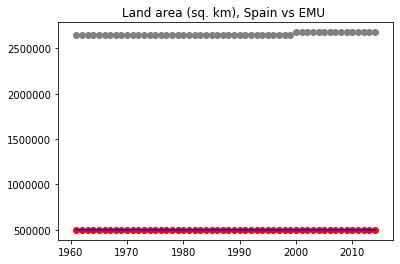

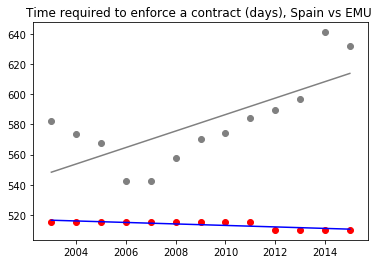

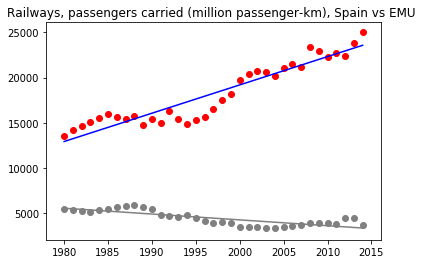

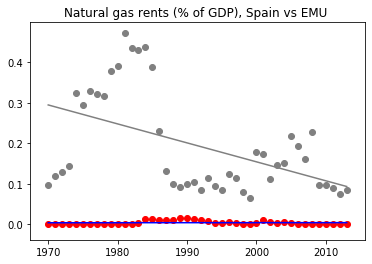

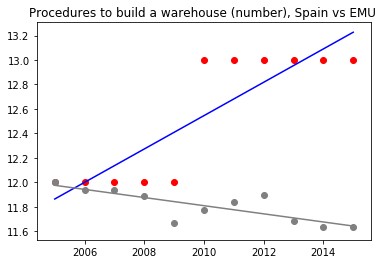

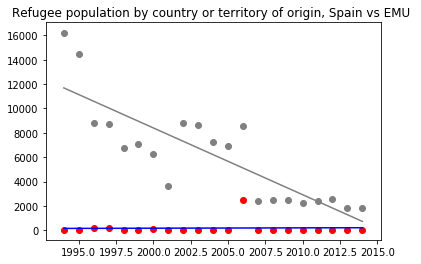

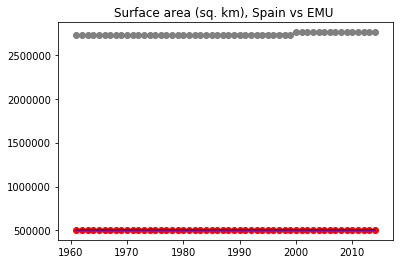

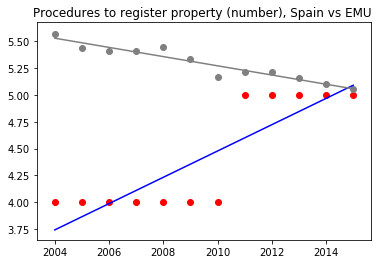

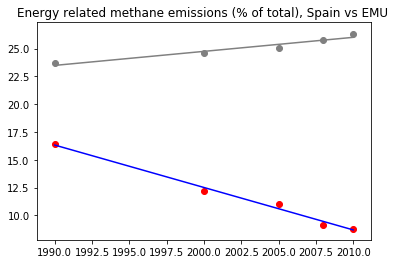

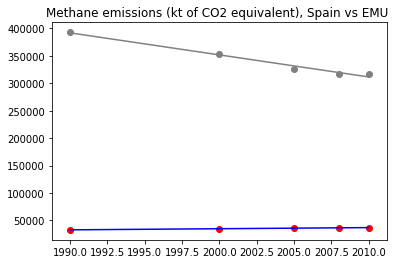

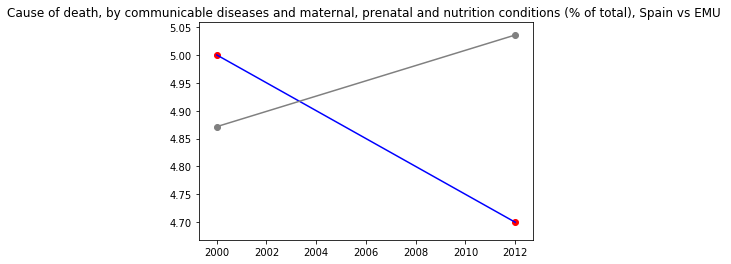

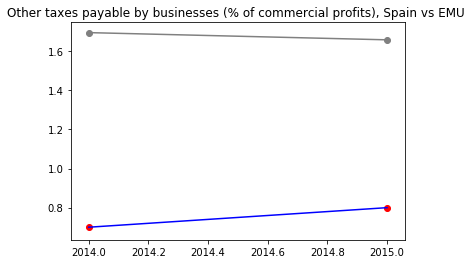

In [150]:
CountryCompare = df_result.CountryCompare.values[0]

for IndicatorName in df_result.tail(50).IndicatorName.values :
    try:
        plt ,df_country,df_rest = Draw_Difference(IndicatorName,CountryCode,CountryCompare)
    except :
        pass


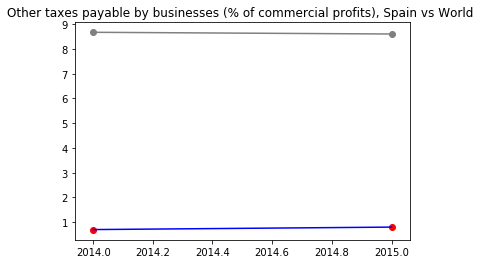

In [18]:
plt ,df_country,df_rest = Draw_Difference(IndicatorName,CountryCode)
    

In [81]:
df = pd.read_sql(f"""SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = 'WLD'
                        AND IndicatorName LIKE  '%Tax%'  order by 1  """,

           conn)
df

,IndicatorName
0,Firms expected to give gifts in meetings with ...
1,Firms that do not report all sales for tax pur...
2,Labor tax and contributions (% of commercial p...
3,Number of visits or required meetings with tax...
4,Other taxes (% of revenue)
5,Other taxes payable by businesses (% of commer...
6,Profit tax (% of commercial profits)
7,Tax payments (number)
8,Tax revenue (% of GDP)
9,Taxes on goods and services (% of revenue)


In [129]:

IndicatorName = 'GDP (constant LCU)'
CountryCode   = 'WLD'

df = pd.read_sql(f"""SELECT distinct(IndicatorName) as IndicatorName
                   FROM Indicators
                   WHERE  CountryCode  = 'ESP'
                          AND IndicatorName LIKE  '%Tax%'   """,
           conn)
df

SQL=f""" SELECT IndicatorName,IndicatorCode,Year,AVG(Value)
                   FROM Indicators
                   WHERE IndicatorName = 'Adolescent fertility rate (births per 1,000 women ages 15-19)' 
                     AND CountryCode   = 'EMU' 
                     AND Year >= (SELECT min(Year) FROM Indicators  WHERE IndicatorName = 'Adolescent fertility rate (births per 1,000 women ages 15-19)' AND CountryCode   = 'ESP')
                     AND Year <= (SELECT max(Year) FROM Indicators  WHERE IndicatorName = 'Adolescent fertility rate (births per 1,000 women ages 15-19)' AND CountryCode   = 'ESP')
                     Group by Year"""
df = pd.read_sql(SQL,   conn)
df



,IndicatorName,IndicatorCode,Year,AVG(Value)
0,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,27.301838
1,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1961,28.377710
2,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1962,29.420392
3,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1963,30.061220
4,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1964,30.707481
5,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1965,31.391725
6,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1966,32.128836
7,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1967,32.912433
8,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1968,33.106171
9,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1969,33.282543


In [189]:
# Debug only
IndicatorName = 'Alternative and nuclear energy (% of total energy use)'
CountryCode2 = 'EMU'
CountryCode1 = 'SPA'
SQL=  f"""
SELECT IndicatorName
                   FROM Indicators
                   WHERE IndicatorName like '%nuclear%' 
                     AND CountryCode   = 'SPA' 
                     """
print(SQL)
otro =  pd.read_sql(SQL,conn)
otro


SELECT IndicatorName
                   FROM Indicators
                   WHERE IndicatorName like '%nuclear%' 
                     AND CountryCode   = 'SPA' 
                     


,IndicatorName
